## KEYS

In [158]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import scipy
from scipy import stats
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv

CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931
genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
           'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
           'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
           'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
           'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
           'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
           'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']
dic = {genes[i]:total[i] for i in range(len(genes))}

def make_sorter(l):
    """
    Create a dict from the list to map to 0..len(l)
    Returns a mapper to map a series to this custom sort order
    """
    sort_order = {k:v for k,v in zip(l, range(len(l)))}
    return lambda s: s.map(lambda x: sort_order[x])

### High and Low Expression

In [159]:
import pandas as pd
import seaborn as sns

# IDENTIFYING HIGH AND LOW EXPRESSION GENES IN ANCESTORS AND MA
CC2931_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2931_raw', delimiter = '\t')
CC2344_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2344_raw', delimiter = '\t')
CC2931_raw.set_index('genes', inplace = True)
CC2344_raw.set_index('genes', inplace = True)

for i in CC2344 + CC2931:
    if 'CC2931' in i:
        CC2931_raw[i] = CC2931_raw[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
    if 'CC2344' in i:
        CC2344_raw[i] = CC2344_raw[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)

CC2344_10per = CC2344_raw['CC2344-ANC'].quantile(0.1)
CC2931_10per = CC2931_raw['CC2931-ANC'].quantile(0.1)
CC2344_90per = CC2344_raw['CC2344-ANC'].quantile(0.9)
CC2931_90per = CC2931_raw['CC2931-ANC'].quantile(0.9)

CC2344_low_exp = list(CC2344_raw.loc[CC2344_raw['CC2344-ANC'] <= CC2344_10per].index.values)
CC2931_low_exp = list(CC2931_raw.loc[CC2931_raw['CC2931-ANC'] <= CC2931_10per].index.values)

CC2344_hi_exp = list(CC2344_raw.loc[CC2344_raw['CC2344-ANC'] >= CC2344_90per].index.values)
CC2931_hi_exp = list(CC2931_raw.loc[CC2931_raw['CC2931-ANC'] >= CC2931_90per].index.values)

HL_MAgenes = {}
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        HL_MAgenes[i + "_low"] = list(CC2344_raw.loc[CC2344_raw[i] <= CC2344_10per].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2344_raw.loc[CC2344_raw[i] >= CC2344_90per].index.values)
    if 'CC2931' in i:
        HL_MAgenes[i + "_low"] = list(CC2931_raw.loc[CC2931_raw[i] <= CC2931_10per].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2931_raw.loc[CC2931_raw[i] >= CC2931_90per].index.values)

## CHECKING INTERSECTION SETS OF HIGH AND LOW EXPRESSION FOR EACH GENOTYPE
verify_hi_hi = list(set(CC2344_hi_exp).symmetric_difference(set(CC2931_hi_exp)))
verify_hi_low = list(set.intersection(set(CC2344_hi_exp), set(CC2931_low_exp))) #noticed points of intersection between sites of high and low expression
verify_low_hi = list(set.intersection(set(CC2344_low_exp), set(CC2931_hi_exp)))
verify_low_low = list(set(CC2344_low_exp).symmetric_difference(set(CC2931_low_exp)))

### Expression levels of DEGs

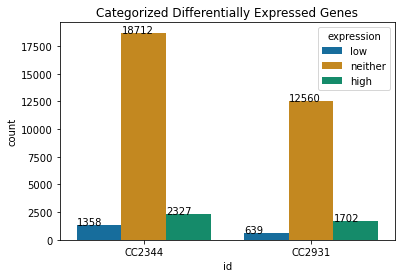

In [3]:
## EVALUATING EXPRESSION OF DEGs_v6
DEGs_v6 = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')
DEGs_v6 = pd.melt(DEGs_v6, value_vars = genes)
DEGs_v6.dropna(subset = ['value'], inplace=True)
DEGs_v6['id'] = 'nan'
DEGs_v6['expression'] = 'neither'

for i in list(DEGs_v6.index.values):
    if 'CC2344' in dic[DEGs_v6.at[i, 'variable']]:
        DEGs_v6.at[i, 'id'] = 'CC2344'
        DEGs_v6.at[i, 'sample'] = dic[DEGs_v6.at[i, 'variable']]
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_low"]:
            DEGs_v6.at[i, 'expression'] = 'low'
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_hi"]:
            DEGs_v6.at[i, 'expression'] = 'high'
    else:
        DEGs_v6.at[i, 'id'] = 'CC2931'
        DEGs_v6.at[i, 'sample'] = dic[DEGs_v6.at[i, 'variable']]
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_low"]:
            DEGs_v6.at[i, 'expression'] = 'low'
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_hi"]:
            DEGs_v6.at[i, 'expression'] = 'high'
            
DEGs_v6_no_neither = DEGs_v6.loc[DEGs_v6['expression'].isin(['high', 'low'])]

## GRAPH OF CATEGORIZED DEGs            
g = sns.countplot(data = DEGs_v6, x = 'id', hue = 'expression', palette = sns.color_palette('colorblind'))
for p in g.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)
g.set_title('Categorized Differentially Expressed Genes')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/categorized_DEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

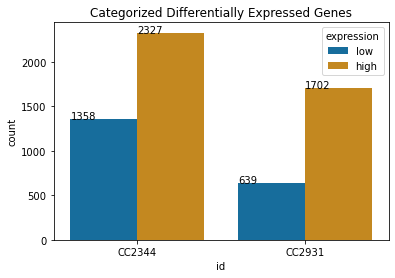

In [4]:
## GRAPH OF CATEGORIZED DEGs without NEITHER
ax = sns.countplot(data = DEGs_v6_no_neither, x = 'id', hue = 'expression', palette = sns.color_palette('colorblind'))
for p in ax.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
ax.set_title('Categorized Differentially Expressed Genes')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/categorized_DEGs_without_neither.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### DEGs Gene Annotation

In [46]:
# ## CONVERTING GENEIDs DEGs_v6 to DEGs_v5
# UNIPROT = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/annotation_package/edited_anno/UNIPROT_BY_GENENAME', delimiter = '\t')
# geneID = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5_to_v6_liftover/preliminary_v6_Cre_liftover.tsv', delimiter = '\t', header = None)
# geneID.columns = ['v6', 'v5']
# DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')
# DEGs_v5 = {}

# for i in genes:
#     gene = DEGs[i].dropna()
#     equivalent_v5 = geneID.loc[geneID['v6'].isin(gene.values.tolist())]
#     DEGs_v5[dic[i]] = equivalent_v5['v5'].values.tolist()
# DEGs_v5 = pd.DataFrame({ key:pd.Series(value) for key, value in DEGs_v5.items() })

# ## CONVERTING DEGs of high and low expression FROM V6 to V5
# CC2344_DEGs_HL = DEGs_v6_no_neither.loc[DEGs_v6_no_neither['id'] == 'CC2344']
# CC2344_DEGs_HIGH = CC2344_DEGs_HL.loc[CC2344_DEGs_HL['expression'] == 'high']
# CC2344_DEGs_LOW = CC2344_DEGs_HL.loc[CC2344_DEGs_HL['expression'] == 'low']
# CC2344_DEGs_HIGH_v6 = geneID.loc[geneID['v6'].isin(CC2344_DEGs_HIGH['value'].values.tolist())]
# CC2344_DEGs_LOW_v6 = geneID.loc[geneID['v6'].isin(CC2344_DEGs_LOW['value'].values.tolist())]
# CC2344_DEGs_HIGH_v5 = CC2344_DEGs_HIGH_v6['v5'].values.tolist()
# CC2344_DEGs_LOW_v5 = CC2344_DEGs_LOW_v6['v5'].values.tolist()

# CC2931_DEGs_HL = DEGs_v6_no_neither.loc[DEGs_v6_no_neither['id'] == 'CC2931']
# CC2931_DEGs_HIGH = CC2931_DEGs_HL.loc[CC2931_DEGs_HL['expression'] == 'high']
# CC2931_DEGs_LOW = CC2931_DEGs_HL.loc[CC2931_DEGs_HL['expression'] == 'low']
# CC2931_DEGs_HIGH_v6 = geneID.loc[geneID['v6'].isin(CC2931_DEGs_HIGH['value'].values.tolist())]
# CC2931_DEGs_LOW_v6 = geneID.loc[geneID['v6'].isin(CC2931_DEGs_LOW['value'].values.tolist())]
# CC2931_DEGs_HIGH_v5 = CC2931_DEGs_HIGH_v6['v5'].values.tolist()
# CC2931_DEGs_LOW_v5 = CC2931_DEGs_LOW_v6['v5'].values.tolist()

# ## CONVERTING DEGs_v5 from "Cre" format to "CHLRE"
# edited_DEGs_v5 = DEGs_v5.replace({'Cre':'CHLRE_', '.g':'G'}, regex = True)
# edited_DEGs_v5['ending'] = 'V5'
# for i in edited_DEGs_v5.columns:
#     edited_DEGs_v5[i] = edited_DEGs_v5[i] + edited_DEGs_v5['ending']
# del edited_DEGs_v5['ending']

# ## GENE ANNOTATION - GENEID
# GENEID = {}
# UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
# gene_intersect = list(set.intersection(set(CC2344_DEGs_HIGH_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2344_DEGs_HIGH_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_DEGs_HIGH.txt', sep = ',', index = False, header = True)

# GENEID = {}
# gene_intersect = list(set.intersection(set(CC2344_DEGs_LOW_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2344_DEGs_LOW_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_DEGs_LOW.txt', sep = ',', index = False, header = True)

# GENEID = {}
# gene_intersect = list(set.intersection(set(CC2931_DEGs_HIGH_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2931_DEGs_HIGH_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2931_DEGs_HIGH.txt', sep = ',', index = False, header = True)

# GENEID = {}
# gene_intersect = list(set.intersection(set(CC2931_DEGs_LOW_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2931_DEGs_LOW_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2931_DEGs_LOW.txt', sep = ',', index = False, header = True)

# GENEID = {}
# GENEID_1 = {}

# for i in CC2344:
#     gene = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect = list(set.intersection(set(gene), set(UNIPROT_GENENAME)))
#     specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
#     geneid = specific_genes['GENEID'].values.tolist()
#     GENEID[i] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_combined.txt', sep = ',', index = False, header = True)

# CC2344_list = []
# for i in CC2344:
#     gene = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect = list(set.intersection(set(gene), set(UNIPROT_GENENAME)))
#     specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
#     geneid = specific_genes['GENEID'].values.tolist()
#     GENEID[i] = geneid
#     item = GENEID[i]
#     CC2344_list += item
# GENEID_DF = pd.DataFrame({'CC2344_combined_1':CC2344_list})
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_combined_1.txt', sep = ',', index = False, header = True)
    
# for i in CC2931:
#     gene_1 = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME_1 = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect_1 = list(set.intersection(set(gene_1), set(UNIPROT_GENENAME_1)))
#     specific_genes_1 = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect_1)]
#     geneid_1 = specific_genes_1['GENEID'].values.tolist()
#     GENEID_1[i] = geneid_1
# GENEID_DF_1 = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID_1.items() })
# GENEID_DF_1.to_csv('DEGs/sortedby_geneid/CC2931_combined.txt', sep = ',', index = False, header = True)

# CC2931_list = []
# for i in CC2931:
#     gene = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect = list(set.intersection(set(gene), set(UNIPROT_GENENAME)))
#     specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
#     geneid = specific_genes['GENEID'].values.tolist()
#     GENEID[i] = geneid
#     item = GENEID[i]
#     CC2931_list += item
# GENEID_DF = pd.DataFrame({'CC2931_combined_1':CC2931_list})
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2931_combined_1.txt', sep = ',', index = False, header = True)

# ## GENE ANNOTATION - CHROMID
# for i in CC2344:
#     gene = edited_DEGs_v5[i].dropna().values.tolist()
#     GENEID[i] = gene
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_chromid/CC2344_combined.txt', sep = ',', index = False, header = True)
    
# for i in CC2931:
#     gene_1 = edited_DEGs_v5[i].dropna().values.tolist()
#     GENEID_1[i] = gene_1
# GENEID_DF_1 = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID_1.items() })
# GENEID_DF_1.to_csv('DEGs/sortedby_chromid/CC2931_combined.txt', sep = ',', index = False, header = True)

# ## EXPORTING HIGH AND LOW EXPRESSION GENEID FOR CC2344 AND CC2931
# gene = geneID.loc[geneID['v6'].isin(CC2344_low_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2344_LOW_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2344_low_exp.txt', sep = ',', index = False, header = True)
                  
# gene = geneID.loc[geneID['v6'].isin(CC2931_low_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2931_LOW_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2931_low_exp.txt', sep = ',', index = False, header = True)

# gene = geneID.loc[geneID['v6'].isin(CC2344_hi_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2344_HIGH_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2344_hi_exp.txt', sep = ',', index = False, header = True)

# gene = geneID.loc[geneID['v6'].isin(CC2931_hi_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2931_HIGH_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2931_hi_exp.txt', sep = ',', index = False, header = True)

### DEGs DAVID Annotation

In [160]:
import pandas as pd

## OPENING DAVID ANNOTATION CHART
CC2344_AS = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_ALL_SAMPLES_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_AS = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_ALL_SAMPLES_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_HIGH_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_HIGH_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_LO = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_LOW_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_LO = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_LOW_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_DEGs_LO = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_DEGs_LOW_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_DEGs_LO = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_DEGs_LOW_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_DEGs_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_DEGs_HIGH_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_DEGs_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_DEGs_HIGH_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]

In [161]:
def david_anno(CC2344_HI, CC2931_HI, high):
    "'returns a dataframe containing the first five shared annotations across samples within a genotype and shared'"
    import pandas as pd
    
    CC2344_HI_KEGG = CC2344_HI.loc[CC2344_HI['Category'] == 'KEGG_PATHWAY']
    CC2344_HI_CC = CC2344_HI.loc[CC2344_HI['Category'] == 'GOTERM_CC_DIRECT']
    CC2344_HI_BP = CC2344_HI.loc[CC2344_HI['Category'] == 'GOTERM_BP_DIRECT']
    CC2344_HI_MF = CC2344_HI.loc[CC2344_HI['Category'] == 'GOTERM_MF_DIRECT']
    
    CC2931_HI_KEGG = CC2931_HI.loc[CC2931_HI['Category'] == 'KEGG_PATHWAY']
    CC2931_HI_CC = CC2931_HI.loc[CC2931_HI['Category'] == 'GOTERM_CC_DIRECT']
    CC2931_HI_BP = CC2931_HI.loc[CC2931_HI['Category'] == 'GOTERM_BP_DIRECT']
    CC2931_HI_MF = CC2931_HI.loc[CC2931_HI['Category'] == 'GOTERM_MF_DIRECT']

    ## CELLULAR COMPONENT (CC)
    CC2344_HI_CC = CC2344_HI_CC.sort_values(by = ['Count'], ascending = False)
    CC2344_HI_CC.reset_index(inplace = True)
    CC2344_HI_CC['Term'] = CC2344_HI_CC['Term'].str.split('~', expand = True)[1];
    
    CC2931_HI_CC = CC2931_HI_CC.sort_values(by = ['Count'], ascending = False)
    CC2931_HI_CC.reset_index(inplace = True)
    CC2931_HI_CC['Term'] = CC2931_HI_CC['Term'].str.split('~', expand = True)[1];

    ## BIOLOGICAL PROCESSES (BP)
    CC2344_HI_BP = CC2344_HI_BP.sort_values(by = ['Count'], ascending = False)
    CC2344_HI_BP.reset_index(inplace = True)
    CC2344_HI_BP['Term'] = CC2344_HI_BP['Term'].str.split('~', expand = True)[1];
    
    CC2931_HI_BP = CC2931_HI_BP.sort_values(by = ['Count'], ascending = False)
    CC2931_HI_BP.reset_index(inplace = True)
    CC2931_HI_BP['Term'] = CC2931_HI_BP['Term'].str.split('~', expand = True)[1];

    ## MOLECULAR FUNCTION (MF)
    CC2344_HI_MF = CC2344_HI_MF.sort_values(by = ['Count'], ascending = False)
    CC2344_HI_MF.reset_index(inplace = True)
    CC2344_HI_MF['Term'] = CC2344_HI_MF['Term'].str.split('~', expand = True)[1];
    
    CC2931_HI_MF = CC2931_HI_MF.sort_values(by = ['Count'], ascending = False)
    CC2931_HI_MF.reset_index(inplace = True)
    CC2931_HI_MF['Term'] = CC2931_HI_MF['Term'].str.split('~', expand = True)[1];

    ## KEGG PATHWAY (KEGG)
    if CC2344_HI_KEGG.values.tolist() != []:
        CC2344_HI_KEGG = CC2344_HI_KEGG.sort_values(by = ['Count'], ascending = False)
        CC2344_HI_KEGG.reset_index(inplace = True)
        CC2344_HI_KEGG['Term'] = CC2344_HI_KEGG['Term'].str.split(':', expand = True)[1];

    if CC2931_HI_KEGG.values.tolist() != []:
        CC2931_HI_KEGG = CC2931_HI_KEGG.sort_values(by = ['Count'], ascending = False)
        CC2931_HI_KEGG.reset_index(inplace = True)
        CC2931_HI_KEGG['Term'] = CC2931_HI_KEGG['Term'].str.split(':', expand = True)[1];

    terms_CC = list(set.intersection(set(CC2344_HI_CC.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_CC.iloc[:5]['Term'].values.tolist())))
    terms_BP = list(set.intersection(set(CC2344_HI_BP.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_BP.iloc[:5]['Term'].values.tolist())))
    terms_MF = list(set.intersection(set(CC2344_HI_MF.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_MF.iloc[:5]['Term'].values.tolist())))
    terms_KEGG = list(set.intersection(set(CC2344_HI_KEGG.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_KEGG.iloc[:5]['Term'].values.tolist())))

    ## COMPILATION
    HEGs_1 = pd.DataFrame(); CC2344_HEGs_1 = pd.DataFrame(); CC2931_HEGs_1 = pd.DataFrame(); HEGs_2 = pd.DataFrame(); CC2344_HEGs_2 = pd.DataFrame(); CC2931_HEGs_2 = pd.DataFrame(); HEGs_3 = pd.DataFrame(); CC2344_HEGs_3 = pd.DataFrame(); CC2931_HEGs_3 = pd.DataFrame(); HEGs_4 = pd.DataFrame(); CC2344_HEGs_4 = pd.DataFrame(); CC2931_HEGs_4 = pd.DataFrame();
    
    HEGs_1['terms'] = terms_MF
    col1 = CC2344_HI_MF.loc[CC2344_HI_MF['Term'].isin(terms_MF)]
    col2 = CC2931_HI_MF.loc[CC2931_HI_MF['Term'].isin(terms_MF)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_MF))
    col2 = col2.sort_values('Term', key=make_sorter(terms_MF))
    HEGs_1['count'] = col1['Count'] + col2['Count']
    HEGs_1['sample'] = 'both'
    CC2344_HEGs_1['terms'] = CC2344_HI_MF.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_1['count'] = CC2344_HI_MF['Count'].iloc[:5]
    CC2931_HEGs_1['terms'] = CC2931_HI_MF.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_1['count'] = CC2931_HI_MF['Count'].iloc[:5]
    CC2344_HEGs_1['sample'] = 'CC2344'
    CC2931_HEGs_1['sample'] = 'CC2931'
    HEGs_1 = pd.concat([HEGs_1, CC2344_HEGs_1, CC2931_HEGs_1], axis = 0)
    HEGs_1['type'] = 'molecular function'

    HEGs_2['terms'] = terms_BP
    col1 = CC2344_HI_BP.loc[CC2344_HI_BP['Term'].isin(terms_BP)]
    col2 = CC2931_HI_BP.loc[CC2931_HI_BP['Term'].isin(terms_BP)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_BP))
    col2 = col2.sort_values('Term', key=make_sorter(terms_BP))
    HEGs_2['count'] = col1['Count'] + col2['Count']
    HEGs_2['sample'] = 'both'
    CC2344_HEGs_2['terms'] = CC2344_HI_BP.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_2['terms'] = CC2931_HI_BP.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_2['count'] = CC2344_HI_BP['Count'].iloc[:5]
    CC2931_HEGs_2['count'] = CC2931_HI_BP['Count'].iloc[:5]
    CC2344_HEGs_2['sample'] = 'CC2344'
    CC2931_HEGs_2['sample'] = 'CC2931'
    HEGs_2 = pd.concat([HEGs_2, CC2344_HEGs_2, CC2931_HEGs_2], axis = 0)
    HEGs_2['type'] = 'biological processes'

    HEGs_3['terms'] = terms_CC
    col1 = CC2344_HI_CC.loc[CC2344_HI_CC['Term'].isin(terms_CC)]
    col2 = CC2931_HI_CC.loc[CC2931_HI_CC['Term'].isin(terms_CC)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_CC))
    col2 = col2.sort_values('Term', key=make_sorter(terms_CC))
    HEGs_3['count'] = col1['Count'] + col2['Count']
    HEGs_3['sample'] = 'both'
    CC2344_HEGs_3['terms'] = CC2344_HI_CC.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_3['terms'] = CC2931_HI_CC.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_3['count'] = CC2344_HI_CC['Count'].iloc[:5]
    CC2931_HEGs_3['count'] = CC2931_HI_CC['Count'].iloc[:5]
    CC2344_HEGs_3['sample'] = 'CC2344'
    CC2931_HEGs_3['sample'] = 'CC2931'
    HEGs_3 = pd.concat([HEGs_3, CC2344_HEGs_3, CC2931_HEGs_3], axis = 0)
    HEGs_3['type'] = 'cellular component'

    HEGs_4['terms'] = terms_KEGG
    col1 = CC2344_HI_KEGG.loc[CC2344_HI_KEGG['Term'].isin(terms_KEGG)]
    col2 = CC2931_HI_KEGG.loc[CC2931_HI_KEGG['Term'].isin(terms_KEGG)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_KEGG))
    col2 = col2.sort_values('Term', key=make_sorter(terms_KEGG))
    HEGs_4['count'] = col1['Count'] + col2['Count']
    HEGs_4['sample'] = 'both'
    CC2344_HEGs_4['terms'] = CC2344_HI_KEGG.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_4['terms'] = CC2931_HI_KEGG.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_4['count'] = CC2344_HI_KEGG['Count'].iloc[:5]
    CC2931_HEGs_4['count'] = CC2931_HI_KEGG['Count'].iloc[:5]
    CC2344_HEGs_4['sample'] = 'CC2344'
    CC2931_HEGs_4['sample'] = 'CC2931'
    HEGs_4 = pd.concat([HEGs_4, CC2344_HEGs_4, CC2931_HEGs_4], axis = 0)
    HEGs_4['type'] = 'kegg pathway'

    HEGs = pd.concat([HEGs_1, HEGs_2, HEGs_3, HEGs_4], axis = 0)
    HEGs['expression'] = high
    return HEGs

In [162]:
DEGs = david_anno(CC2344_AS, CC2931_AS, 'differential')
HEGs = david_anno(CC2344_HI, CC2931_HI, 'high')
LEGs = david_anno(CC2344_LO, CC2931_LO, 'low')
DEGs_HI = david_anno(CC2344_DEGs_HI, CC2931_DEGs_HI, 'high')
DEGs_LO = david_anno(CC2344_DEGs_LO, CC2931_DEGs_LO, 'low')

### DAVID ANNOTATION IMAGES

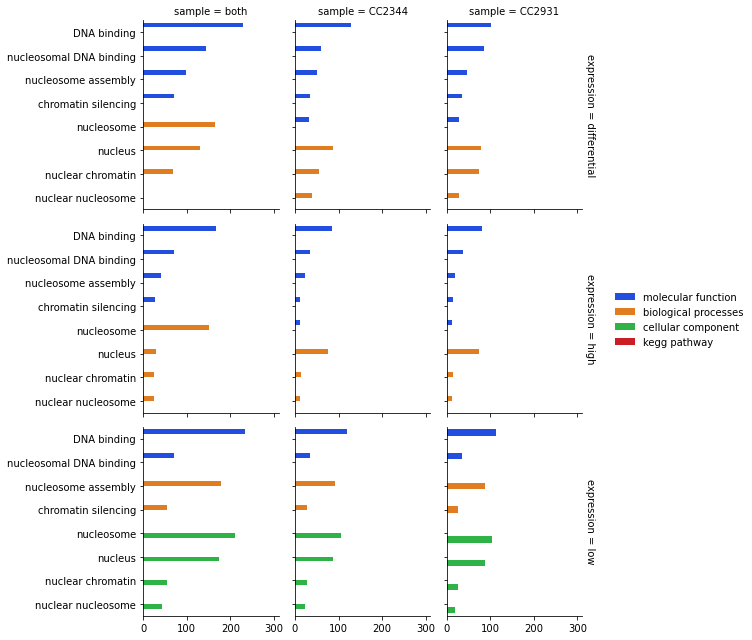

In [31]:
##COMBINED ANNOTATION CHART
COMBINED = pd.concat([DEGs, HEGs, LEGs], axis = 0)
g = sns.FacetGrid(COMBINED, row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

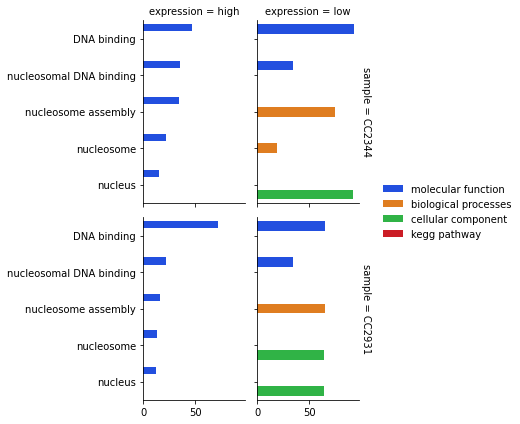

In [224]:
COMBINED = pd.concat([DEGs_HI, DEGs_LO], axis = 0)
g = sns.FacetGrid(COMBINED.loc[COMBINED['sample'].isin(['CC2344', 'CC2931'])], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/differentially expressed HEGs & LEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

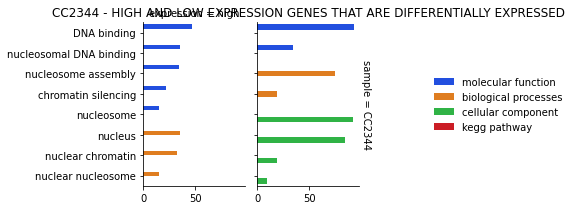

In [221]:
COMBINED = pd.concat([DEGs_HI, DEGs_LO], axis = 0)
g = sns.FacetGrid(COMBINED.loc[COMBINED['sample'] == 'CC2344'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.title("CC2344 - HIGH AND LOW EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2344 differentially expressed HEGs & LEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

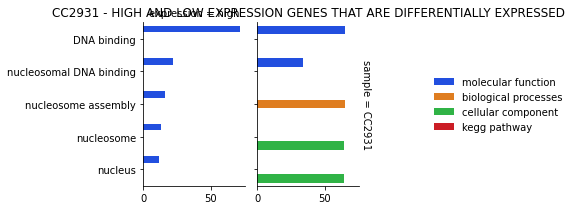

In [222]:
COMBINED = pd.concat([DEGs_HI, DEGs_LO], axis = 0)
g = sns.FacetGrid(COMBINED.loc[COMBINED['sample'] == 'CC2931'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.title("CC2931 - HIGH AND LOW EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2931 differentially expressed HEGs & LEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


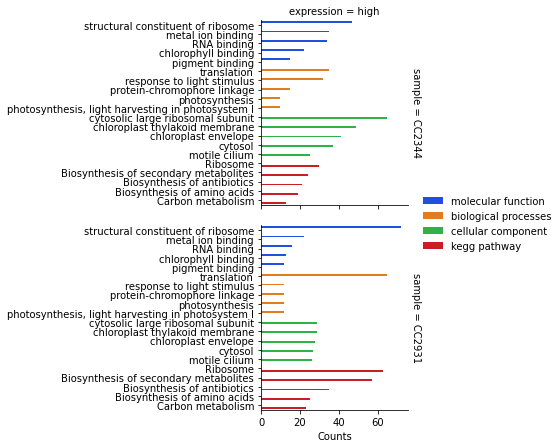

In [219]:
g = sns.FacetGrid(DEGs_HI.loc[DEGs_HI['sample'].isin(['CC2344', 'CC2931'])], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.xlabel('Counts')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/differentially expressed HEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


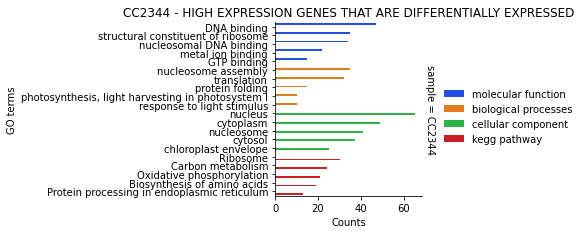

In [216]:
g = sns.FacetGrid(DEGs_HI.loc[DEGs_HI['sample'] == 'CC2344'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.xlabel('Counts')
plt.ylabel('GO terms')
plt.title("CC2344 - HIGH EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2344 differentially expressed HEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


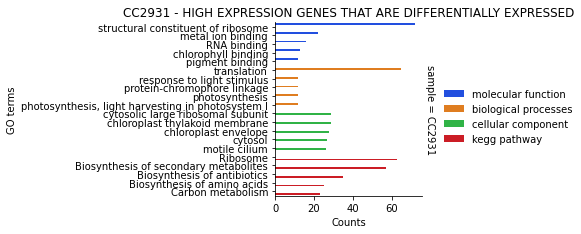

In [215]:
g = sns.FacetGrid(DEGs_HI.loc[DEGs_HI['sample'] == 'CC2931'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.xlabel('Counts')
plt.ylabel('GO terms')
plt.title("CC2931 - HIGH EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2931 differentially expressed HEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

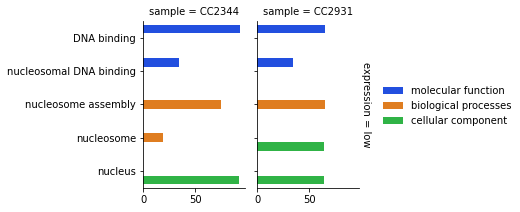

In [213]:
g = sns.FacetGrid(DEGs_LO.loc[DEGs_LO['sample'].isin(['CC2344', 'CC2931'])], row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
g.fig.subplots_adjust(top=0.9)
# plt.title("LOW EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/differentially expressed LEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

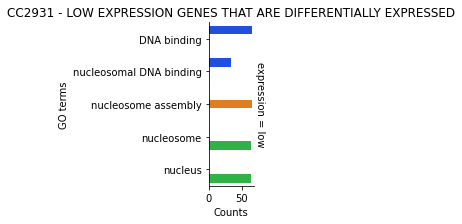

In [208]:
g = sns.FacetGrid(DEGs_LO.loc[DEGs_LO['sample'] == 'CC2931'], row = "expression", col = "sample", margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.xlabel('Counts')
plt.ylabel('GO terms')
plt.title("CC2931 - LOW EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2931 differentially expressed LEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

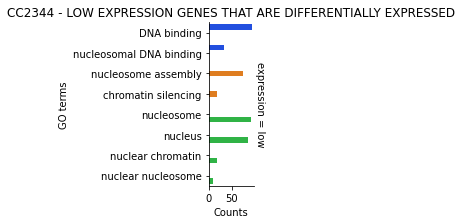

In [207]:
g = sns.FacetGrid(DEGs_LO.loc[DEGs_LO['sample'] == 'CC2344'], row = "expression", col = "sample", margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.xlabel('Counts')
plt.ylabel('GO terms')
plt.title("CC2344 - LOW EXPRESSION GENES THAT ARE DIFFERENTIALLY EXPRESSED")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2344 differentially expressed LEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


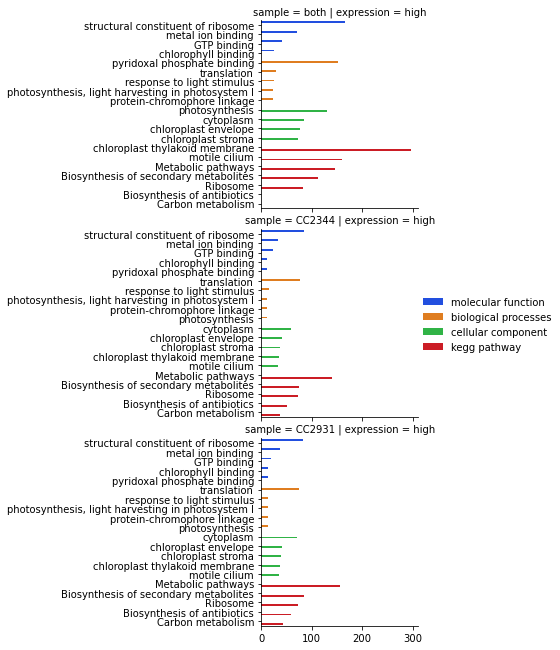

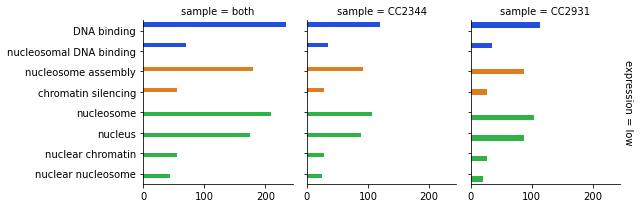

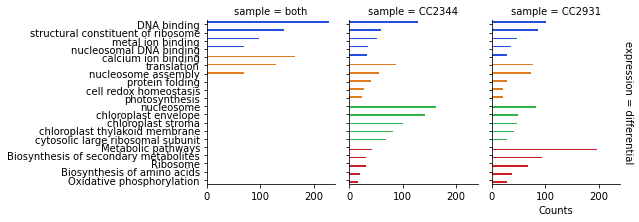

In [32]:
a = sns.FacetGrid(HEGs, row = "sample", col = "expression", palette = 'Set1')
a.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
a.add_legend()
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/HEGs_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

b = sns.FacetGrid(LEGs, row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
b.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/LEGs_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

c = sns.FacetGrid(DEGs, row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
c.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.xlabel('Counts')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/DEGs_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

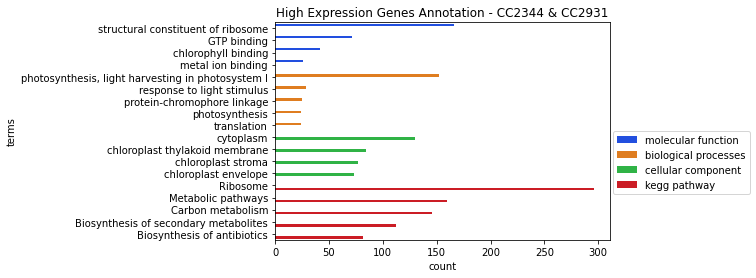

In [33]:
a = sns.barplot(data = HEGs.loc[HEGs['sample'] == 'both'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('High Expression Genes Annotation - CC2344 & CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/HEGs_AS.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

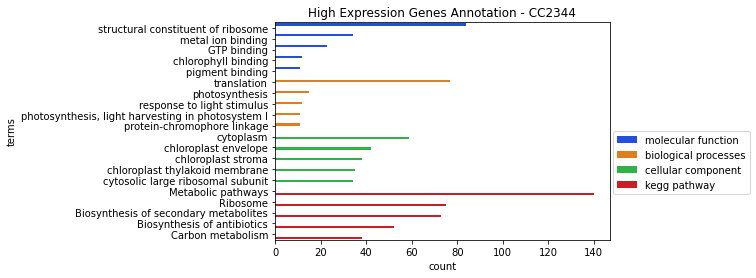

In [34]:
a = sns.barplot(data = HEGs.loc[HEGs['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('High Expression Genes Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/HEGs_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

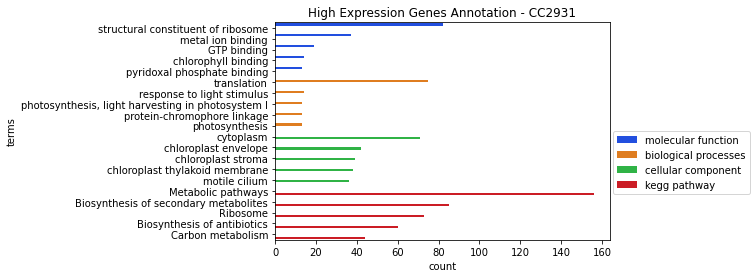

In [35]:
a = sns.barplot(data = HEGs.loc[HEGs['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('High Expression Genes Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/HEGs_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

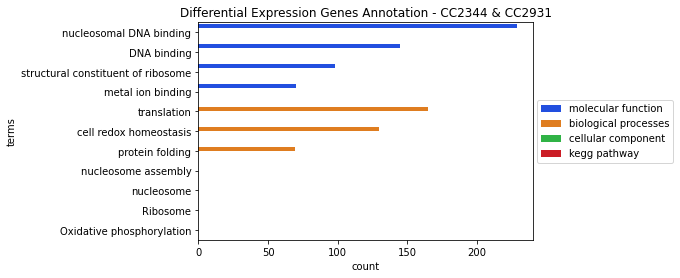

In [36]:
a = sns.barplot(data = DEGs.loc[DEGs['sample'] == 'both'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Differential Expression Genes Annotation - CC2344 & CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/DEGs_AS.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

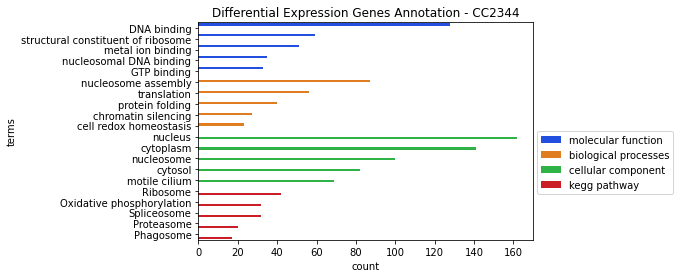

In [37]:
a = sns.barplot(data = DEGs.loc[DEGs['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Differential Expression Genes Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/DEGs_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

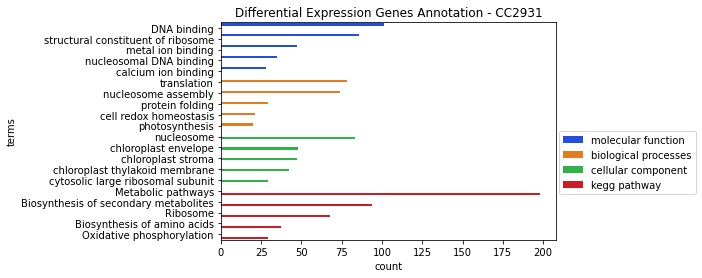

In [38]:
a = sns.barplot(data = DEGs.loc[DEGs['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Differential Expression Genes Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/DEGs_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

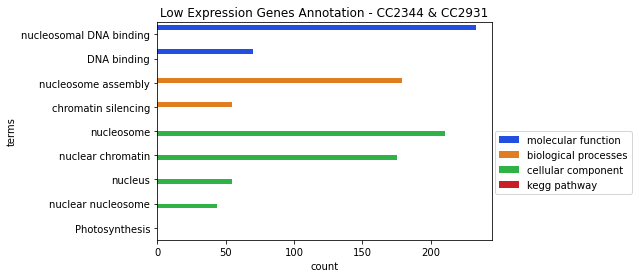

In [39]:
a = sns.barplot(data = LEGs.loc[LEGs['sample'] == 'both'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Low Expression Genes Annotation - CC2344 & CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/LEGs_AS.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

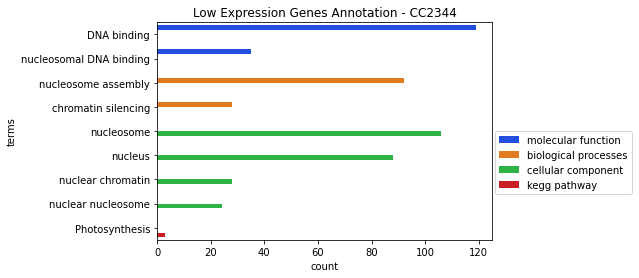

In [40]:
a = sns.barplot(data = LEGs.loc[LEGs['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Low Expression Genes Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/LEGs_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

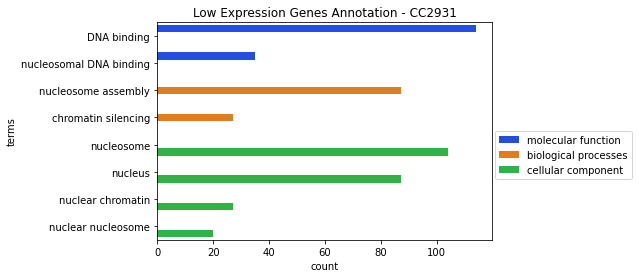

In [41]:
a = sns.barplot(data = LEGs.loc[LEGs['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Low Expression Genes Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/LEGs_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

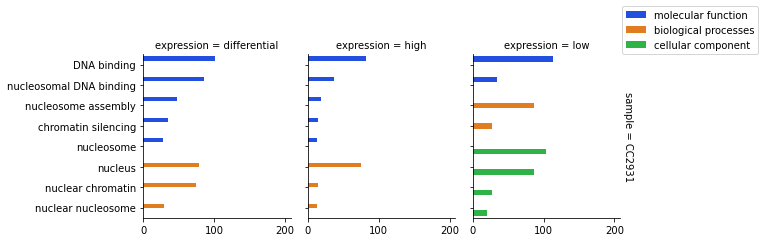

In [42]:
COMBINED = pd.concat([DEGs, HEGs, LEGs], axis = 0)
sns.set_palette("RdBu")
e = sns.FacetGrid(COMBINED.loc[COMBINED['sample'] == 'CC2931'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
e.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/COMBINED_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

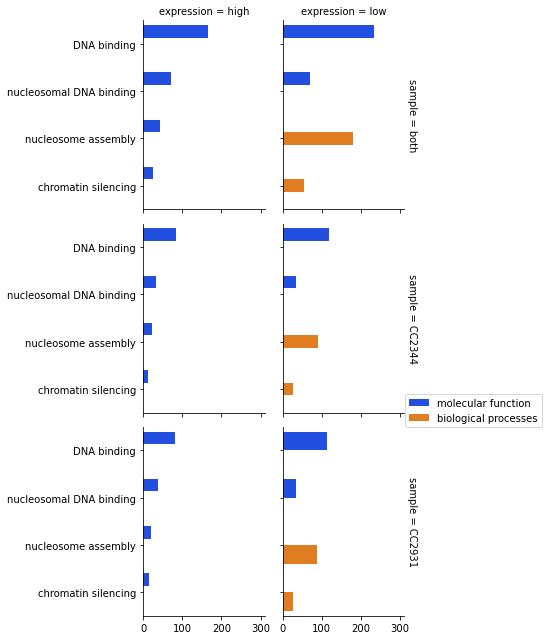

In [43]:
COMBINED = pd.concat([HEGs, LEGs], axis = 0)
sns.set_palette("RdBu")
e = sns.FacetGrid(COMBINED.loc[COMBINED['type'].isin(['molecular function', 'biological processes', 'kegg pathway'])], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
e.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)